In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/medium_articles_t5_small_tokenized.hf.zip -d /content

Archive:  /content/drive/MyDrive/medium_articles_t5_small_tokenized.hf.zip
   creating: /content/medium_articles_t5_small_tokenized.hf/
  inflating: /content/__MACOSX/._medium_articles_t5_small_tokenized.hf  
  inflating: /content/medium_articles_t5_small_tokenized.hf/.DS_Store  
  inflating: /content/__MACOSX/medium_articles_t5_small_tokenized.hf/._.DS_Store  
  inflating: /content/medium_articles_t5_small_tokenized.hf/dataset_dict.json  
  inflating: /content/__MACOSX/medium_articles_t5_small_tokenized.hf/._dataset_dict.json  
   creating: /content/medium_articles_t5_small_tokenized.hf/test/
  inflating: /content/__MACOSX/medium_articles_t5_small_tokenized.hf/._test  
   creating: /content/medium_articles_t5_small_tokenized.hf/train/
  inflating: /content/__MACOSX/medium_articles_t5_small_tokenized.hf/._train  
   creating: /content/medium_articles_t5_small_tokenized.hf/validation/
  inflating: /content/__MACOSX/medium_articles_t5_small_tokenized.hf/._validation  
  inflating: /conte

In [3]:
!pip install transformers
!pip install datasets rouge-score
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.5 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=649cd49b95fe83bdfd4b2eea4d201c095eceade4a3a5358b4f47513bdf83f7f4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.1 MB/s eta 0:00:00


In [4]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from IPython.display import clear_output

from matplotlib import pyplot as plt

import transformers
from datasets import load_dataset, load_metric, load_from_disk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
import evaluate

In [5]:
model_checkpoint = "t5-small"

In [6]:
medium_datasets = load_from_disk('/content/medium_articles_t5_small_tokenized.hf')

In [7]:
medium_datasets

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'input_ids', 'attention_mask', 'labels', 'decoder_attention_mask'],
        num_rows: 100000
    })
    validation: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'input_ids', 'attention_mask', 'labels', 'decoder_attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['title', 'text', 'url', 'authors', 'timestamp', 'tags', 'input_ids', 'attention_mask', 'labels', 'decoder_attention_mask'],
        num_rows: 8000
    })
})

In [8]:
class SoRA_Linear(nn.Module):
  def __init__(self, old_module, rmax, *args, **kwargs):
    super().__init__()

    assert isinstance(old_module, nn.Linear)

    self.old_linear = old_module
    self.old_linear.weight.requires_grad = False

    in_features = old_module.in_features
    out_features = old_module.out_features

    self.lora_matrix_B = nn.Parameter(torch.zeros(out_features, rmax))
    self.sora_gate = nn.Parameter(torch.randn(rmax))
    self.lora_matrix_A = nn.Parameter(torch.randn(rmax, in_features))

    self.weight = old_module.weight

  def forward(self, x):
    pretrain_out = self.old_linear(x)

    sora_out = F.linear(x, self.lora_matrix_A)
    sora_out = torch.mul(self.sora_gate, sora_out)
    sora_out = F.linear(sora_out, self.lora_matrix_B)

    return pretrain_out + sora_out

In [9]:
class SoRA_model(nn.Module):

  def __init__(self, model_checkpoint, lora_rmax=30, reg_coef=1):
    super().__init__()

    self.reg_coef = reg_coef

    self.model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
    self.model_config = self.model.config

    self.lora_rmax = lora_rmax

    self.sora_modules = []
    self.sora_gates = []

    self.replace()
    self.freeze()

  def replace(self, ):
    self.replace_recursion(self.model)

  def replace_recursion(self, model):
    for name, module in model.named_children():
      if isinstance(module, nn.Linear):
        new_layer = SoRA_Linear(module, self.lora_rmax)

        self.sora_modules.append(new_layer)
        self.sora_gates.append(new_layer.sora_gate)

        setattr(model, name, new_layer)

      else:
        self.replace_recursion(module)

  def freeze(self):
    for name, param in self.model.named_parameters():
      if ("lora_" in name) or ("sora_" in name):
        param.requires_grad = True
      else:
        param.requires_grad = False

  def gate(self, lr):
    for sora_gate in self.sora_gates:
      sora_gate.data = torch.sgn(sora_gate) * torch.clamp(torch.abs(sora_gate) - lr * self.reg_coef, min=0)


  def forward(self, *args, **kwargs):
    return self.model(*args, **kwargs)

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
N_EPOCH = 1
BATCH_SIZE = 8
NUM_WORKERS = 2
ETA = 0.001
LR = 0.0001
REG = 10
R_MAX = 8

In [12]:
sora_t5 = SoRA_model(model_checkpoint, lora_rmax=R_MAX, reg_coef=REG)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [13]:
count_parameters(sora_t5)

1343240

In [14]:
loss_fn = nn.CrossEntropyLoss()

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
sora_t5.to(device);

In [16]:
parameters_without_gates = []
parameters_only_gates = []

for name, param in sora_t5.named_parameters():
  if "lora_" in name:
    parameters_without_gates.append(param)
  elif "sora_" in name:
    parameters_only_gates.append(param)

In [17]:
class two_Optimizers(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [18]:
rouge = evaluate.load('rouge')

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def compute_metrics(true_ids, pred_ids):
    decoded_preds = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    # labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(true_ids, skip_special_tokens=True)

    results = rouge.compute(predictions=decoded_preds,
                            references=decoded_labels)

    return results

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [20]:
optimizer = two_Optimizers(
    torch.optim.Adam(parameters_without_gates, lr=LR),
    torch.optim.SGD(parameters_only_gates, lr=ETA)
    )

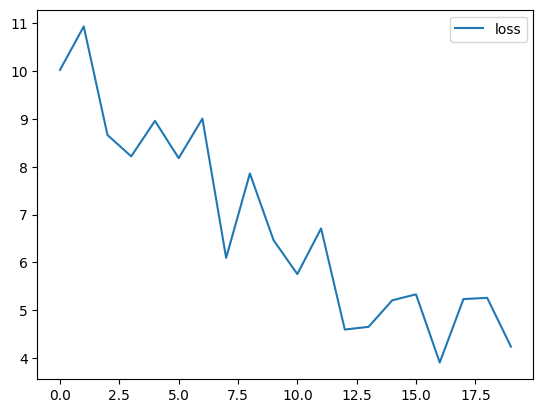

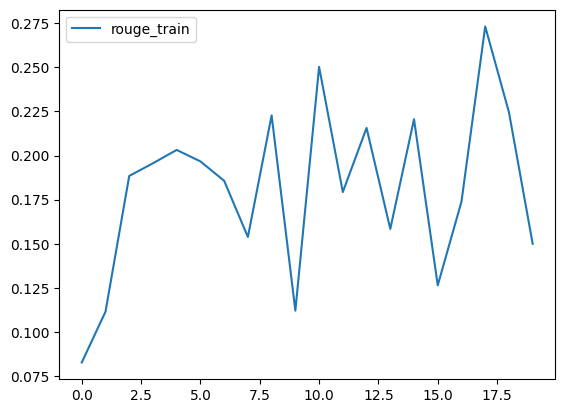

In [ ]:
loader = DataLoader(medium_datasets['train'].with_format("torch"),
                    batch_size=BATCH_SIZE,
                    num_workers=NUM_WORKERS)

for epoch in range(N_EPOCH):

  loss_train_history = []
  rouge_train_history = []
  x_train = []

  val_rouge_history = []
  x_val_rouge_history = []

  iter = 0

  for batch in loader:
    sora_t5.train()
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    decoder_input_ids = batch['labels'].to(device)
    decoder_attention_mask = batch['decoder_attention_mask'].to(device)

    outputs = sora_t5(
        input_ids=input_ids,
        attention_mask=attention_mask,
        decoder_input_ids=decoder_input_ids,
        decoder_attention_mask=decoder_attention_mask
        )

    logits = outputs.logits
    loss = loss_fn(logits.permute([0, 2, 1]), decoder_input_ids)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    sora_t5.gate(ETA)

    loss_train_history.append(loss.item())
    res = compute_metrics(decoder_input_ids, torch.argmax(logits, 2))
    rouge_train_history.append(res['rougeL'])
    x_train.append(iter)
    clear_output(wait=True)

    if iter%10 == 0 and iter != 0:
      with torch.no_grad():
        sora_t5.eval()
        length = len(medium_datasets['validation'])
        val_dataset = medium_datasets['validation'].shuffle()

        outputs = []
        true_vals = []
        for val_iter, i in enumerate(range(0, length, 2*BATCH_SIZE)):
          batch_eval = val_dataset.select(range(i, i+2*BATCH_SIZE)).with_format("torch")
          outputs += sora_t5.model.generate(batch_eval['input_ids'], max_new_tokens=32)
          true_vals += batch_eval['labels']
          if val_iter > 10:
            break

        res = compute_metrics(true_vals, outputs)
        val_rouge_history.append(res['rougeL'])
        x_val_rouge_history.append(iter)

        plt.figure()
        plt.plot(x_val_rouge_history, val_rouge_history, label='rouge_val')
        plt.legend()

      if iter > 30:
        if val_rouge_history[-2] > val_rouge_history[-1]:
          break

    iter += 1
    plt.figure()
    plt.plot(x_train, loss_train_history, label='loss')
    plt.legend()

    plt.figure()
    plt.plot(x_train, rouge_train_history, label='rouge_train')
    plt.legend()

    plt.show()
    if iter > 100:
      break

In [ ]:
plt.plot(x_train, loss_train_history)

In [34]:
s = 0
for param in sora_t5.sora_gates:
  s += torch.sum((param == 0).int()).data

s

tensor(28)

In [37]:
sum(p.numel() for p in sora_t5.sora_gates)

776

In [38]:
import pickle

In [41]:
results = {
    'train_loss': loss_train_history,
    'train_rougeL': rouge_train_history,
    'train_iter_grid': x_train,
    'val_rougeL': val_rouge_history,
    'val_iter_grid': x_val_rouge_history
}

In [43]:
with open('results2.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)